# Working with CMIP6 data in the JASMIN Object Store
This Notebook describes how to set up a virtual environment and then work with CMIP6 data in the JASMIN Object Store (stored in Zarr format).

## Start by creating a virtual environment and getting the packages installed...

In [1]:
# Import the required packages
import virtualenv
import pip
import os

# Define and create the base directory install virtual environments
venvs_dir = os.path.join(os.path.expanduser("~"), "nb-venvs")

if not os.path.isdir(venvs_dir):
    os.makedirs(venvs_dir)
    
# Define the venv directory
venv_dir = os.path.join(venvs_dir, 'venv-cmip6-zarr')

In [2]:
# Create the virtual environment
virtualenv.create_environment(venv_dir)

copying /opt/jaspy/bin/python => /home/users/astephen/nb-venvs/venv-cmip6-zarr/bin/python


In [3]:
# Activate the venv
activate_file = os.path.join(venv_dir, "bin", "activate_this.py")
exec(open(activate_file).read(), dict(__file__=activate_file))

In [4]:
# Install a set of required packages via `pip`
requirements = ['fsspec', 'intake', 'intake_esm', 'aiohttp']

pip.main(["install", "--prefix", venv_dir, "--upgrade", "pip"])

for pkg in requirements:
    pip.main(["install", "--prefix", venv_dir, pkg])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


# Accessing CMIP6 Data from the JASMIN (Zarr) Object Store

**Pre-requisites**
1. Required packages: `['xarray', 'zarr', 'fsspec', 'intake', 'intake_esm', 'aiohttp']`
2. Data access: must be able to see JASMIN Object Store for CMIP6 (currently inside JASMIN firewall)

## Step 1: Import required packages

In [5]:
import xarray as xr
import intake
import intake_esm
import fsspec

## Step 2: read the CMIP6 Intake (ESM) catalog from github
We define a collection ("col") that can be searched/filtered for required datasets.

In [11]:
col_url = "https://raw.githubusercontent.com/cedadev/" \
          "cmip6-object-store/master/catalogs/ceda-zarr-cmip6-jasmin.json"
col = intake.open_esm_datastore(col_url)

How many datasets are currently stored?

In [12]:
f'There are {len(col.df)} datasets'

'There are 149339 datasets'

## Step 3: Filter the catalog for historical and future data
In this example, we want to compare the surface temperature ("tas") from the
UKESM1-0-LL model, for a historical and future ("ssp585-bgc") scenario.

In [13]:
cat = col.search(source_id="UKESM1-0-LL",
    experiment_id=["historical", "ssp585-bgc"], 
    member_id=["r4i1p1f2", "r12i1p1f2"],
    table_id="Amon",
    variable_id="tas")

# Extract the single record subsets for historical and future experiments
hist_cat = cat.search(experiment_id='historical')
ssp_cat = cat.search(experiment_id='ssp585-bgc')

## Step 4: Convert to xarray datasets

Define a quick function to convert a catalog to an xarray `Dataset`.

In [14]:
def cat_to_ds(cat):
    zarr_path = cat.df['zarr_path'][0]
    fsmap = fsspec.get_mapper(zarr_path)
    return xr.open_zarr(fsmap, consolidated=True, use_cftime=True)

Extract the `tas` (surface air temperture) variable for the historical and future experiments.

In [15]:
hist_tas = cat_to_ds(hist_cat)['tas']
ssp_tas = cat_to_ds(ssp_cat)['tas']

## Step 5: Subtract the historical from the future average
Generate time-series means of historical and future data. Subtract the historical from the future scenario and plot the difference.

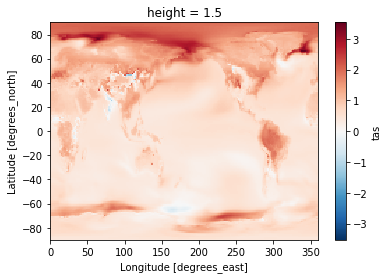

In [17]:
# Calculate time means
diff = ssp_tas.mean(dim="time") - hist_tas.mean(dim="time")

# Plot a map of the time-series means
diff.plot()

## References
- CMIP6 Object Store code (github): https://github.com/cedadev/cmip6-object-store
- This notebook: https://github.com/cedadev/cmip6-object-store/blob/master/notebooks/cmip6-zarr-jasmin.ipynb